# Add/import required packages

In [ ]:
using Pkg
#Pkg.add(url="https://github.com/giordamaug/WiSARDj")
Pkg.add("MLJ")
Pkg.add("MLJBase")
Pkg.add("DataFrames")
Pkg.add("RDatasets")
Pkg.add("Plots")
Pkg.add("Metrics")
Pkg.add("ScikitLearn")
Pkg.add("ScikitLearnBase")
using RDatasets, MLJ, MLJBase, DataFrames, ScikitLearn, ScikitLearnBase, Metrics, Plots

# Load the "iris" daatset

In [2]:
iris = RDatasets.dataset("datasets", "iris");
first(iris, 3) |> pretty

┌─────────────┬────────────┬─────────────┬────────────┬─────────────────────────────────┐
│ SepalLength │ SepalWidth │ PetalLength │ PetalWidth │ Species                         │
│ Float64     │ Float64    │ Float64     │ Float64    │ CategoricalValue{String, UInt8} │
│ Continuous  │ Continuous │ Continuous  │ Continuous │ Multiclass{3}                   │
├─────────────┼────────────┼─────────────┼────────────┼─────────────────────────────────┤
│ 5.1         │ 3.5        │ 1.4         │ 0.2        │ setosa                          │
│ 4.9         │ 3.0        │ 1.4         │ 0.2        │ setosa                          │
│ 4.7         │ 3.2        │ 1.3         │ 0.2        │ setosa                          │
└─────────────┴────────────┴─────────────┴────────────┴─────────────────────────────────┘


# Classification with WiSARDj

In [6]:
using WiSARDj.SciLearnInterface: WiSARDClassifier

with_cv = true
model = WiSARDClassifier(n_bits=8, n_tics=256, bleaching=false, debug=true)

X = Matrix(DataFrames.select(iris, Not([:Species])))
y = vec(Matrix(DataFrames.select(iris, [:Species])))
if with_cv
    ŷ = cross_val_predict(model, X, y; cv=5)
    y_targets = y
else
    train, test = MLJ.partition(eachindex(y), 0.8, shuffle=true, rng=1)
    ScikitLearnBase.fit!(model, X[train,:], y[train,:])
    ŷ = ScikitLearnBase.predict(model, X[test,:])
    y_targets = y[test,:]
end
accuracy = sum(ŷ .== y_targets) / length(y_targets)
println("accuracy: $accuracy")
MLJBase.ConfusionMatrix()(ŷ, coerce(vec(y_targets), OrderedFactor))  # I don't know why we need coerce!end

accuracy: 0.9466666666666667


┌ Warning: Converting array elements to strings before wrapping in a `CategoricalArray`, as `CategoricalArrays.CategoricalValue{String, UInt8}` unsupported by CategoricalArrays. 
└ @ ScientificTypes /Users/maurizio/.julia/packages/ScientificTypes/zv7h0/src/convention/coerce.jl:48


              ┌─────────────────────────────────────────┐
              │              Ground Truth               │
┌─────────────┼─────────────┬─────────────┬─────────────┤
│  Predicted  │   setosa    │  versicol…  │  virginica  │
├─────────────┼─────────────┼─────────────┼─────────────┤
│   setosa    │     50      │      0      │      0      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│  versicol…  │      0      │     46      │      4      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│  virginica  │      0      │      4      │     46      │
└─────────────┴─────────────┴─────────────┴─────────────┘


# Load the "boston" dataset

In [4]:
boston = RDatasets.dataset("MASS", "Boston");
first(boston, 3) |> pretty

┌────────────┬────────────┬────────────┬───────┬────────────┬────────────┬────────────┬────────────┬───────┬───────┬────────────┬────────────┬────────────┬────────────┐
│ Crim       │ Zn         │ Indus      │ Chas  │ NOx        │ Rm         │ Age        │ Dis        │ Rad   │ Tax   │ PTRatio    │ Black      │ LStat      │ MedV       │
│ Float64    │ Float64    │ Float64    │ Int64 │ Float64    │ Float64    │ Float64    │ Float64    │ Int64 │ Int64 │ Float64    │ Float64    │ Float64    │ Float64    │
│ Continuous │ Continuous │ Continuous │ Count │ Continuous │ Continuous │ Continuous │ Continuous │ Count │ Count │ Continuous │ Continuous │ Continuous │ Continuous │
├────────────┼────────────┼────────────┼───────┼────────────┼────────────┼────────────┼────────────┼───────┼───────┼────────────┼────────────┼────────────┼────────────┤
│ 0.00632    │ 18.0       │ 2.31       │ 0.0   │ 0.538      │ 6.575      │ 65.2       │ 4.09       │ 1.0   │ 296.0 │ 15.3       │ 396.9      │ 4.98       │

# Regression with WiSARDj

Mean absolute error: 2.0596700618360333
Mean Squared Error: 10.355470620452314
Coefficient of Determination: 0.8391623485282727


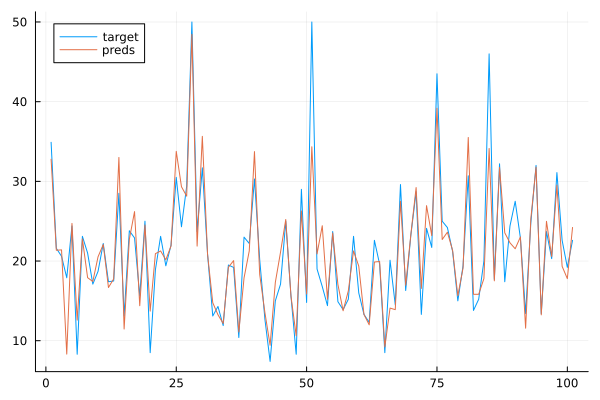

In [8]:
using WiSARDj.SciLearnInterface: WiSARDRegressor

model = WiSARDRegressor(n_bits=64, n_tics=1024, debug=true)

X = Matrix(DataFrames.select(boston, Not([:MedV])))
y = vec(Matrix(DataFrames.select(boston, [:MedV])))
train, test = MLJ.partition(eachindex(y), 0.8, shuffle=true, rng=1)
ScikitLearnBase.fit!(model, X[train,:], y[train,:])
ŷ = ScikitLearnBase.predict(model, X[test,:])
y_targets = vec(y[test,:])
MAE = Metrics.mae(vec(ŷ), y_targets)
MSE = Metrics.mse(vec(ŷ), y_targets)
R2 = Metrics.r2_score(vec(ŷ), y_targets)
println("Mean absolute error: $MAE")
println("Mean Squared Error: $MSE")
println("Coefficient of Determination: $R2")
using Plots
plot(hcat(y_targets, vec(ŷ)), label=["target" "preds"])